In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
all_points = xr.load_dataarray(r'C:\Users\vovam\Desktop\rotations\Leeat Keren\data\all_data.nc')

## First 7 -CD20; CD4; CD8; CD45; HLA Class II; dsDNA; panCK;

There is no panCK in our dataset so I added panK and also added CD3 as it may be a useful marker (Idan's advice)

In [4]:
src = r'Z:\vovam\Vova\data\matrices\8_25'


def load_data(src):
    channels_src = 'channels.txt'
    with open(os.path.join(src, channels_src)) as f:
        channels = f.read().splitlines()

    mat = np.loadtxt(os.path.join(src, 'mat.txt')).astype(np.float32)
    mat = (mat / np.linalg.norm(mat, ord=1, axis=0))
    return mat, channels


needed_channels = load_data(src)[1]

In [6]:
channels_data = all_points.sel(channels = needed_channels)

## Turn tensor into matrix of needed shape, remove negatives, and binarise

In [8]:
channels_mat = np.transpose(channels_data.values, [1, 0, 2, 3])
# channels_mat.shape == (7, 38, 2048, 2048)
print(channels_mat.shape)
channels_mat = channels_mat.reshape((7, -1))
# channels_mat.shape == (7, 38*2048*2048)
print(channels_mat.shape)
channels_mat = channels_mat.clip(min = 0)
channels_mat = 1 * (channels_mat > 0)

(7, 38, 2048, 2048)
(7, 159383552)


## Sum over the columns

In [9]:
counts_mat = channels_mat.sum(axis = 0)
print(counts_mat.shape)

(159383552,)


## Plot results of the counts

Text(0.5, 0, 'Number of active channels on given pixel across all points')

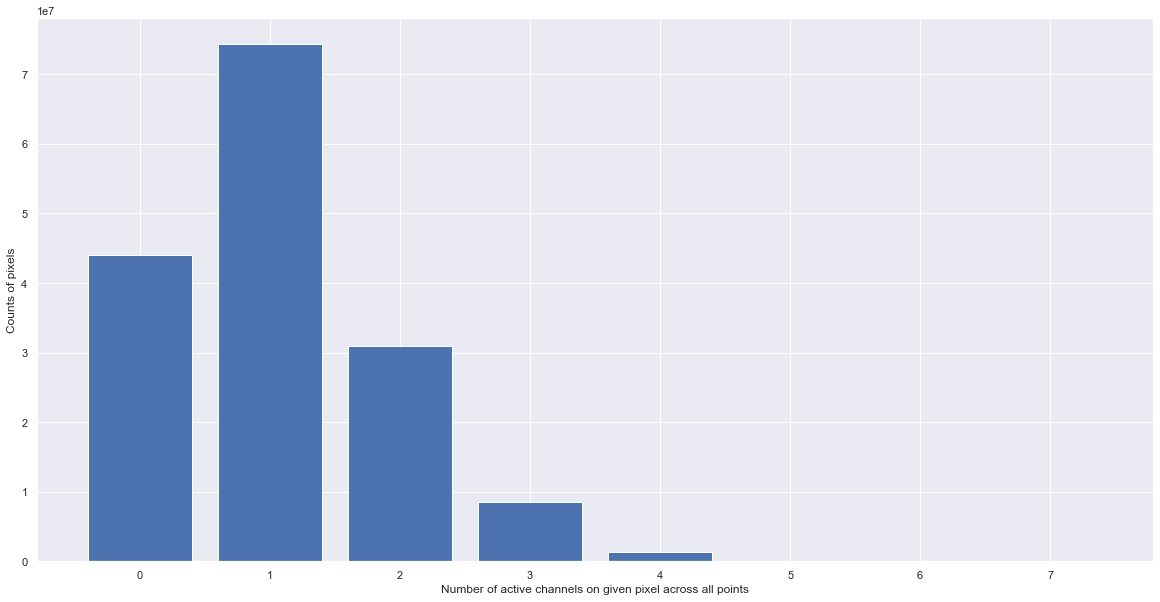

In [10]:
value, counts = np.unique(counts_mat, return_counts=True)
dist = dict(zip(value, counts))
plt.figure(figsize = (20,10))
plt.bar(dist.keys(), dist.values())
plt.ylabel('Counts of pixels')
plt.xlabel('Number of active channels on given pixel across all points')

## Covariance and Correlation matrices of given channels

In [3]:
cov_mat = np.load(r'Z:\vovam\scripts\covP5.npy')

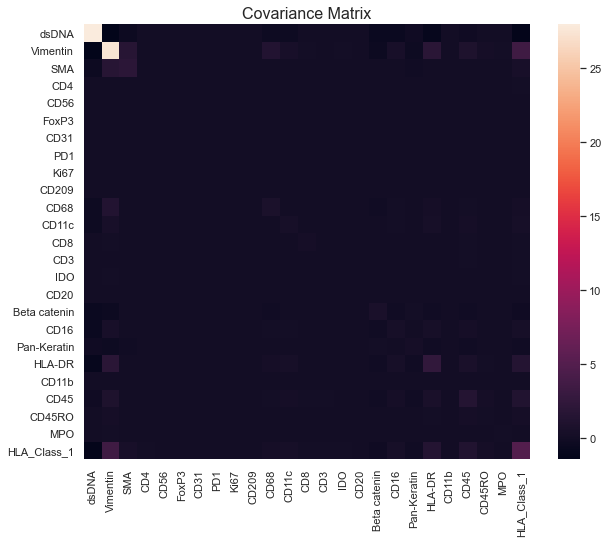

In [4]:
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(10, 8))
sns.heatmap(cov_mat, 
            xticklabels=needed_channels,
            yticklabels=needed_channels)
plt.title('Covariance Matrix', fontsize=16);

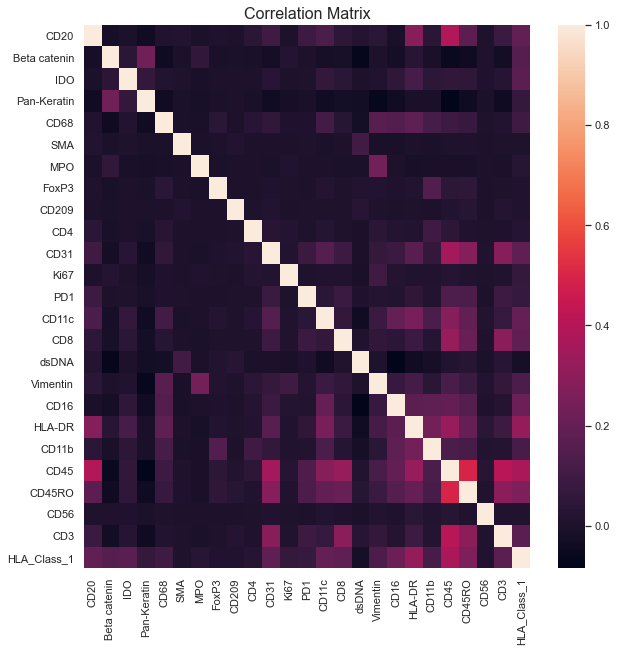

In [3]:
corr_mat = np.load(r'Z:\vovam\scripts\correlation_mat\corr_all_trial.npy')
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(10, 10))
sns.heatmap(corr_mat, 
            xticklabels=needed_channels,
            yticklabels=needed_channels, annot = False)

plt.title('Correlation Matrix', fontsize=16);

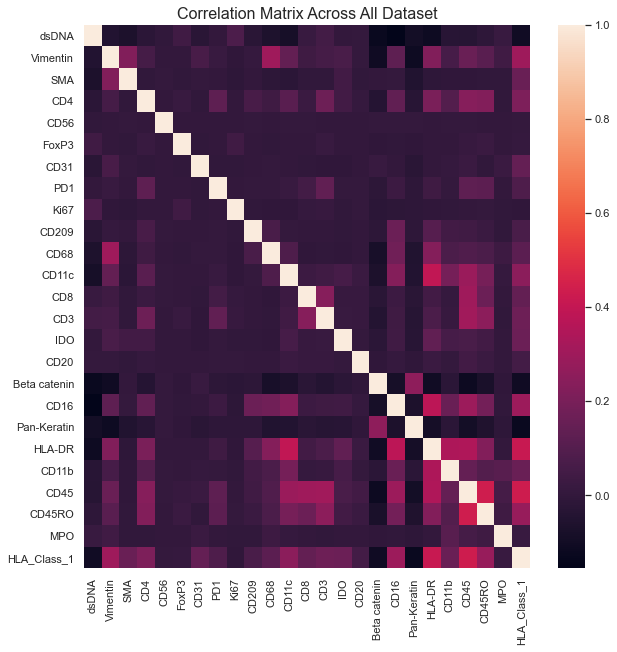

In [5]:
corr_mat = np.load(r'Z:\vovam\scripts\corrP5.npy')
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(10, 10))
sns.heatmap(corr_mat, 
            xticklabels=needed_channels,
            yticklabels=needed_channels, annot = False)

plt.title('Correlation Matrix Across All Dataset', fontsize=16);

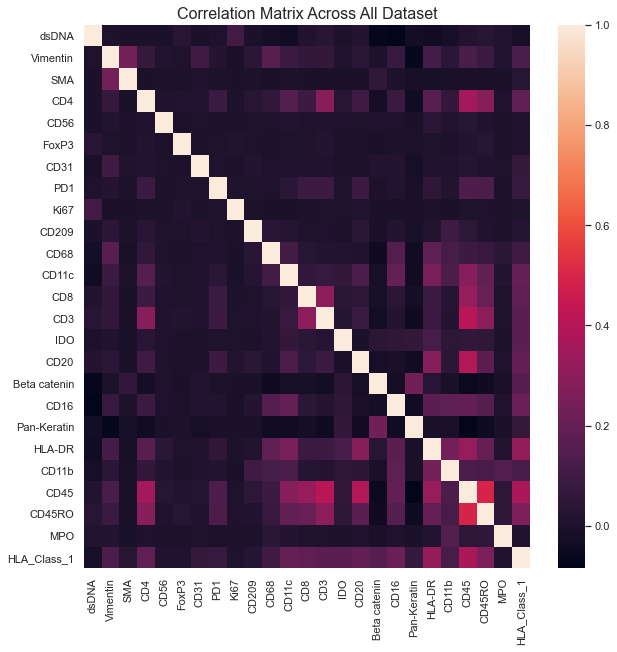

In [6]:
corr_mat = np.load(r'Z:\vovam\scripts\correlation_mat\corr_all.npy')
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(10, 10))
sns.heatmap(corr_mat, 
            xticklabels=needed_channels,
            yticklabels=needed_channels, annot = False)

plt.title('Correlation Matrix Across All Dataset', fontsize=16);

In [8]:
torch.tensor(np.load(r'Z:\vovam\scripts\corrP5.npy'))

tensor([[ 1.0000e+00, -5.1027e-02, -6.7453e-02, -2.3161e-02, -5.1552e-03,
          4.0215e-02, -2.6305e-02,  7.5240e-04,  7.8120e-02, -2.8235e-02,
         -6.3709e-02, -8.3624e-02,  2.0061e-02,  4.8055e-02,  1.6633e-03,
          4.6956e-03, -1.2796e-01, -1.5580e-01, -9.4374e-02, -1.1227e-01,
         -3.3535e-02, -3.8407e-02, -1.3285e-02,  1.6745e-02, -1.0211e-01],
        [-5.1027e-02,  1.0000e+00,  2.2224e-01,  5.2069e-02,  8.4490e-04,
         -1.4194e-03,  6.1976e-02,  1.7947e-02, -9.7152e-03,  1.0839e-02,
          3.0416e-01,  1.4185e-01,  3.7706e-02,  5.6211e-02,  6.6818e-02,
          4.6695e-03, -1.0721e-01,  1.2725e-01, -1.1488e-01,  2.2310e-01,
          5.7250e-02,  1.5640e-01,  1.1442e-01,  4.1330e-02,  2.9710e-01],
        [-6.7453e-02,  2.2224e-01,  1.0000e+00, -6.1246e-03,  5.2905e-03,
         -4.1729e-03,  5.6873e-03,  1.8811e-03, -1.2025e-02, -3.4957e-04,
         -2.0241e-02, -2.3850e-02, -3.3041e-03, -3.7076e-03,  4.3987e-02,
         -3.3826e-03,  5.2788e-04,  

In [2]:
import torch

In [3]:
def corr(x):
        """
        x: [B, C, H, W]
        res: [ C, C]
        """

        # [B, C, H, W] -> [B, C * H * W]
        x = x.view((x.size(1), -1))
        
        # estimated covariance
        x = x - x.mean(dim=-1, keepdim=True)
        
        factor = 1 / (x.shape[-1] - 1)
        
        corr = factor * (x @ x.transpose(-1, -2))
        diagonal = torch.diagonal(corr) #, dim1=-2, dim2=-1)
        stddev = torch.sqrt(diagonal)
        
        corr /= stddev[:, None]
        corr /= stddev[None, :]
        corr = troch.clip(corr, -1, 1)
        
        return corr

In [10]:
all_points = xr.load_dataarray(r'C:\Users\leeatgen.WISMAIN\Desktop\Vova\all_data.nc').sel(fovs=['Point5'], channels=needed_channels).values.astype(np.float16)

In [11]:
channels_mat = torch.tensor(all_points).float()

In [4]:
test = torch.randint(low=0, high=200, size=(10,25,2048,2048)).float()

In [7]:
test.view(test.size(1), -1).shape

torch.Size([25, 41943040])

In [17]:
38*2048*2048

159383552

<AxesSubplot:>

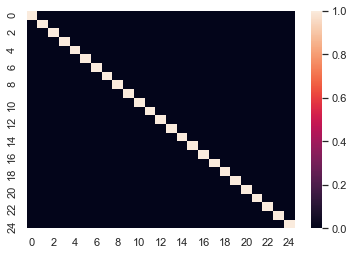

In [169]:
sns.heatmap(corr(test))

<AxesSubplot:>

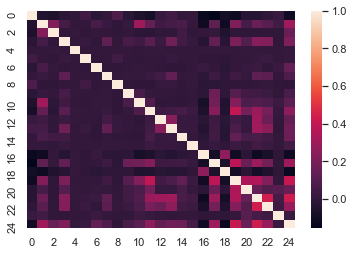

In [208]:
sns.heatmap(corr(channels_mat))

<AxesSubplot:>

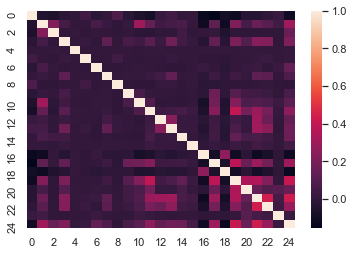

In [209]:
sns.heatmap(corr_mat)

In [161]:
corr_mat = np.clip(corr_mat, -1, 1)

In [178]:
def corr2(x):
        """
        x: [B, C, H, W]
        res: [B, C, C]
        """

        # [B, C, H, W] -> [B, C, H * W]
        x = x.view((x.size(0), x.size(1), -1))
        #x = x.view((x.size(0), -1))
        # estimated covariance
        x = x - x.mean(dim=-1, keepdim=True)
        
        factor = 1 / (x.shape[-1] - 1)
        
        corr = factor * (x @ x.transpose(-1, -2))
        diagonal = torch.diagonal(corr) #, dim1=-2, dim2=-1)
        stddev = np.sqrt(diagonal)
        
        corr = torch.div(corr, stddev[:, None])
        corr = torch.div(corr, stddev[None, :])
        corr = np.clip(corr, -1, 1)
        
        return corr